In [ ]:
!pip install pydicom nilearn

In [ ]:
import os

import pandas as pd
import numpy as np
import pydicom as dcm
import nibabel as nib

from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('./content')

Mounted at ./content


In [ ]:
path = "content/MyDrive/data/"

In [ ]:
os.listdir(path)

['train_series_meta.csv',
 'segmentations',
 'image_level_labels.csv',
 'sample_submission.csv',
 'test_dicom_tags.parquet',
 'test_images',
 'test_series_meta.csv',
 'train.csv',
 'train_dicom_tags.parquet',
 'rsna-2023-abdominal-trauma-detection.zip',
 'merged_df.csv',
 'train_images',
 'try_data']

In [ ]:
df = pd.read_csv(path + '/merged_df.csv')

In [ ]:
df.head()

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,...,spleen_healthy,spleen_low,spleen_high,any_injury,series_id,instance_number,injury_name,path,aortic_hu,incomplete_organ
0,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,362,Active_Extravasation,train_images/10004/21057/362.dcm,146.0,0
1,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,363,Active_Extravasation,train_images/10004/21057/363.dcm,146.0,0
2,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,364,Active_Extravasation,train_images/10004/21057/364.dcm,146.0,0
3,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,365,Active_Extravasation,train_images/10004/21057/365.dcm,146.0,0
4,10004,1,0,0,1,0,1,0,1,0,...,0,0,1,1,21057,366,Active_Extravasation,train_images/10004/21057/366.dcm,146.0,0


In [ ]:
df.columns

Index(['patient_id', 'bowel_healthy', 'bowel_injury', 'extravasation_healthy',
       'extravasation_injury', 'kidney_healthy', 'kidney_low', 'kidney_high',
       'liver_healthy', 'liver_low', 'liver_high', 'spleen_healthy',
       'spleen_low', 'spleen_high', 'any_injury', 'series_id',
       'instance_number', 'injury_name', 'path', 'aortic_hu',
       'incomplete_organ'],
      dtype='object')

### transforms

In [ ]:
from torchvision import transforms

In [ ]:
transform = transforms.Compose([transforms.Resize((256, 256)),
                                 transforms.RandomHorizontalFlip(p=0.5),
                                #  transforms.ColorJitter(brightness=0.2),
                                #  transforms.ColorJitter(contrast=0.2),
                                 transforms.ColorJitter(brightness=0.2, contrast=0.2),
                                #  transforms.RandomAffine(degrees=0, shear=10),
                                 transforms.RandomAffine(degrees=0, scale=(0.8, 1.2)),
                                #  transforms.RandomErasing(p=0.2, scale=(0.02, 0.2)),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                 ])
# 연속 2번 실행 시. 에러 파티

### 데이터 변환 및 augmentation

In [ ]:
from PIL import Image

In [ ]:
def transformed_data(img_path_data):
    trans_data = []

    for file_path in tqdm(img_path_data):
        # DCM 파일 읽기
        dcm_data = dcm.dcmread(path + file_path)
        image_array = dcm_data.pixel_array  # DCM 데이터의 이미지 배열

        # 이미지로 변환
        image = Image.fromarray(image_array).convert("RGB")

        # 이미지 변환 적용
        transformed_image = transform(image)

        # 적용된 이미지를 리스트에 추가
        trans_data.append(transformed_image)

    return trans_data

In [ ]:
# RAM 용량 초과.
transform_imgs = transformed_data(df['path'].tolist())

 99%|█████████▉| 11893/12029 [09:07<17:21,  7.66s/it]

In [ ]:
transform_imgs = transformed_data(df['path'].iloc[:5000].tolist())

100%|██████████| 5000/5000 [01:41<00:00, 49.25it/s]


In [ ]:
transform_imgs = transformed_data(df['path'].iloc[5000:10000].tolist())

100%|██████████| 5000/5000 [01:43<00:00, 48.39it/s]


In [ ]:
transform_imgs = transformed_data(df['path'].iloc[10000:].tolist())

100%|██████████| 2029/2029 [01:28<00:00, 22.88it/s]


### 파일 저장

In [ ]:
import pickle

In [ ]:
with open(path + 'transformed_imgs_3.pkl', 'wb') as f:
    pickle.dump(transform_imgs, f)

### 파일 불러오기

In [ ]:
with open(path + 'transformed_imgs_1.pkl', 'rb') as f:
    x = pickle.load(f)

In [ ]:
len(x)

5000

In [ ]:
x[0].shape

torch.Size([3, 256, 256])

### 시각화 해보기

In [ ]:
import matplotlib.pyplot as plt

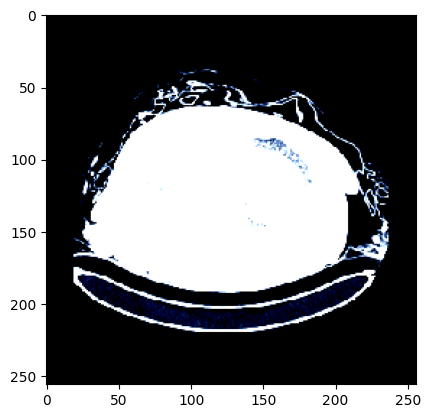

In [ ]:
plt.imshow(x[0].permute(1,2,0));